In [1]:
import scipy.sparse as spr
import scipy.sparse.linalg as spla
import sys
path2oti = '../../../build/'
sys.path.append(path2oti) # Add path to OTI library.

import pyoti.real   as r
import pyoti.sparse as oti 
import pyoti.core   as coti
import pyoti.fem    as fem 

import pyoti.static.onumm1n1    as dual
# import pyoti.static.mdnum2      as md2
# import pyoti.static.mdnum3      as md3
# import pyoti.static.mdnum5      as md5
import pyoti.static.mdnum6      as md6
# import pyoti.static.mdnum10     as md10
# import pyoti.static.onumm1n10   as om1n10
# import pyoti.static.onumm1n2    as om1n2
import pyoti.static.onumm1n5    as om1n5
# import pyoti.static.onumm5n5    as om5n5
# import pyoti.static.onumm2n2    as om2n2
# import pyoti.static.onumm3n3    as om3n3
import pyoti.static.onumm2n10    as om2n10




%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

e  = oti.e
np = oti.np

import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')

global times
from timeit import default_timer as time

from matplotlib import rc

## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
rc('text', usetex=True)

In [2]:
def cylinder(ri, ro, he = 1.0, element_order = 1, quads = False, 
           quad_incomplete = 1, quad_linear = 1, structured = False, save=False):
    """
    PORPUSE: Define a cylinder section mesh.
    """
    #***************************************************************************************************
    import gmsh

    gmsh.initialize()
    # gmsh.fltk.initialize()

    # Lets create a simple square element:
    model = gmsh.model
    geo   = model.geo
    option= gmsh.option

    P1 = geo.addPoint( 0.0, 0.0, 0.0, he, 1)
    P2 = geo.addPoint( 0.0,  ri, 0.0, he, 2)
    P3 = geo.addPoint(  ri, 0.0, 0.0, he, 3)
    P4 = geo.addPoint( 0.0,  ro, 0.0, he, 4)
    P5 = geo.addPoint(  ro, 0.0, 0.0, he, 5)

    C1 = geo.addCircleArc(P2,P1,P3)
    C2 = geo.addCircleArc(P5,P1,P4)
    
    geo.remove([P1])
    
    L1 = geo.addLine(P4,P2) # Left
    L2 = geo.addLine(P3,P5) # bottom

    loop1 = geo.addCurveLoop([C1,L2,C2,L1])

    surface = geo.addPlaneSurface([loop1])

    model.addPhysicalGroup( 0, [P1],        100 )
    model.addPhysicalGroup( 0, [P2],        101 )
    model.addPhysicalGroup( 0, [P3],        102 )
    model.addPhysicalGroup( 0, [P4],        103 )
    model.addPhysicalGroup( 0, [P5],        104 )

    model.addPhysicalGroup( 1, [C1],        201 )
    model.addPhysicalGroup( 1, [C2],        202 )
    model.addPhysicalGroup( 1, [L1],        203 )
    model.addPhysicalGroup( 1, [L2],        204 )

    model.addPhysicalGroup( 2, [surface],   301 )
    
    model.setPhysicalName( 0, 100, "center"  )
    model.setPhysicalName( 0, 101, "ri_left"  )
    model.setPhysicalName( 0, 102, "ri_right" )
    model.setPhysicalName( 0, 103, "ro_left"  )
    model.setPhysicalName( 0, 104, "ro_right" )

    model.setPhysicalName( 1, 201, "ri"    )
    model.setPhysicalName( 1, 202, "ro"    )
    model.setPhysicalName( 1, 203, "left"  )
    model.setPhysicalName( 1, 204, "right" )

    model.setPhysicalName( 2, 301, "domain"      )

    
    geo.synchronize()

    option.setNumber('Mesh.ElementOrder',element_order)


    # Recombine if quads are wanted.
    if quads:

        # Set body to recombine into quads.
        option.setNumber('Mesh.SecondOrderIncomplete',quad_incomplete)
        option.setNumber('Mesh.SecondOrderLinear',    quad_linear    )
        option.setNumber('Mesh.RecombineAll',         1)

    else:

        option.setNumber('Mesh.SecondOrderIncomplete',quad_incomplete)
        option.setNumber('Mesh.SecondOrderLinear',    quad_linear    )
        option.setNumber('Mesh.RecombineAll',         0)

    # end if 

    if structured:
        nels_L = int((ro-ri)/he)+1
        nels_C = min(int((ri*np.pi*2)/(4*he))+1,100)
        model.mesh.setTransfiniteCurve(L1,nels_L)
        model.mesh.setTransfiniteCurve(L2,nels_L)
        model.mesh.setTransfiniteCurve(C1,nels_C)
        model.mesh.setTransfiniteCurve(C2,nels_C)
        model.mesh.setTransfiniteSurface(surface)#,"left",[P2,P3,P4])
    # end if 

    model.mesh.generate(2)

    if save:
        gmsh.write("cylinder.msh")
    # end if 

    Th = fem.mesh.from_gmsh(gmsh)
#     Th = None

    gmsh.finalize()

    return Th

#-----------------------------------------------------------------------------------------------------

In [3]:
#*****************************************************************************************************
def solve_2d_linear_elasticity(Th, E, nu, ri, Pi, ro, Po, stats=True, solver = 'SuperLU'):
    
    global times
    from timeit import default_timer as time
    
    start_time = time()
    
    mu = E/(2*(1+nu))
    
    c1 = E*nu/((1+nu)*(1-2*nu))
    c2 = 2*mu
    c3 = mu
    c4 = c1+c2
    
    ndim_analysis = 2
    els = Th.elements[2]

    fem.end_elements()
    
    nNodes = Th.x.shape[0]
    nDOF = 2*nNodes
    
    K = alg.lil_matrix((nDOF,nDOF))
    f = alg.zeros((nDOF,1))
    
    K[nNodes,nNodes] = 1.0 # Removes "center" node.
    K[0,0] = 1.0 # Removes "center" node.
    
    # 
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=2)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = True)

            fh = alg.zeros( ( elem.nbasis, 1 ) )
            
            # Temps
            
            NxT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            NyT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
            
            NxNx = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NxNy = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NyNx = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NyNy = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )

            NN_tmp1 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NN_tmp2 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            NN_tmp3 = alg.zeros( ( elem.nbasis, elem.nbasis ), nip = elem.nip )
            
            tmp11 = alg.zeros( ( elem.nbasis, elem.nbasis ) )
            tmp12 = alg.zeros( ( elem.nbasis, elem.nbasis ) )
            tmp21 = alg.zeros( ( elem.nbasis, elem.nbasis ) )
            tmp22 = alg.zeros( ( elem.nbasis, elem.nbasis ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()

            Nx = elem.Nx
            Ny = elem.Ny
            N  = elem.N
            
            alg.transpose(Nx, out = NxT)
            alg.transpose(Ny, out = NyT)
            
            alg.dot( NxT, Nx, out = NxNx )
            alg.dot( NyT, Ny, out = NyNy )
            alg.dot( NyT, Nx, out = NyNx )
            alg.dot( NxT, Ny, out = NxNy )

            # problem = intV( c1*dx(vx)*dx(ux) + c1*dy(vy)*dx(ux) ) + \
            #           intV( c1*dx(vx)*dy(uy) + c1*dy(vy)*dy(uy) ) + \
            #           intV( c2*dx(vx)*dx(ux) + c2*dy(vy)*dy(uy) ) + \
            #           intV( c3*dy(vx)*dy(ux) + c3*dx(vy)*dy(ux) ) + \
            #           intV( c3*dy(vx)*dx(uy) + c3*dx(vy)*dx(uy) ) + \
            #           intS( 'in' , fxi*vx + fyi*vy ) + \
            #           intS( 'out', fxo*vx + fyo*vy ) + \
            #           on(   'left' , ux, 0.0) + \
            #           on(   'right', uy, 0.0)
            #  
            # c1*NxNx + c2*NxNx + c3*NyNy # vx, ux
            # c1*NxNy + c3*NyNx           # vx, uy
            # c1*NyNx + c3*NxNy           # vy, ux
            # c1*NyNy + c2*NyNy + c3*NxNx # vy, uy
            
            # c4 = c1+c2

#             tmp11.set(0)
#             tmp12.set(0)
#             tmp21.set(0)
#             tmp22.set(0)
            
            # alg.gauss_integrate( c4*NxNx + c3*NyNy , elem.dV,out=tmp11) # vx,ux            
            alg.mul(      c4,    NxNx, out=NN_tmp1 )
            alg.mul(      c3,    NyNy, out=NN_tmp2 )
            alg.sum( NN_tmp1, NN_tmp2, out=NN_tmp3 )
            alg.gauss_integrate( NN_tmp3, elem.dV, out = tmp11 ) # vx,ux
            
            # alg.gauss_integrate( c1*NxNy + c3*NyNx , elem.dV,out=tmp12) # vx,uy
            alg.mul(      c1,    NxNy, out=NN_tmp1 )
            alg.mul(      c3,    NyNx, out=NN_tmp2 )
            alg.sum( NN_tmp1, NN_tmp2, out=NN_tmp3 )
            alg.gauss_integrate( NN_tmp3, elem.dV, out = tmp12 ) # vx,uy
            
            # alg.gauss_integrate( c1*NyNx + c3*NxNy , elem.dV,out=tmp21) # vy,ux
            alg.mul(      c1,    NyNx, out=NN_tmp1 )
            alg.mul(      c3,    NxNy, out=NN_tmp2 )
            alg.sum( NN_tmp1, NN_tmp2, out=NN_tmp3 )
            alg.gauss_integrate( NN_tmp3, elem.dV, out = tmp21 ) # vy,ux
            
            # alg.gauss_integrate( c4*NyNy + c3*NxNx , elem.dV,out=tmp22) # vy,uy
            alg.mul(      c4,    NyNy, out=NN_tmp1 )
            alg.mul(      c3,    NxNx, out=NN_tmp2 )
            alg.sum( NN_tmp1, NN_tmp2, out=NN_tmp3 )
            alg.gauss_integrate( NN_tmp3, elem.dV, out = tmp22 ) # vy,uy
            

                      
            # assemble globals
            
            for k in range(elems.size):
        
                ii=int(elems[k])
                
                i1 = ii
                i2 = ii + nNodes # Move DOF for second variable
                
                for l in range(elems.size):

                    jj=int(elems[l])
                    
                    j1 = jj
                    j2 = jj + nNodes # Move DOF for second variable
                    
                    K[i1,j1] = K[i1,j1] + tmp11[k,l]
                    
                    K[i1,j2] = K[i1,j2] + tmp12[k,l]
                    
                    K[i2,j1] = K[i2,j1] + tmp21[k,l]
                    
                    K[i2,j2] = K[i2,j2] + tmp22[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()   

    end_assmbly_time = time()
    
    
    # 
    els = Th.group_names['ri']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=4)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            nxel = alg.zeros( ( elem.nbasis, 1 ) )
            xel  = alg.zeros( ( elem.nbasis, 1 ) )
            nyel = alg.zeros( ( elem.nbasis, 1 ) )
            yel  = alg.zeros( ( elem.nbasis, 1 ) )            

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = alg.transpose(elem.N)
            
            for k in range(elems.size):
                xel[k,0] = Th.x[int(elems[k]),0]
                yel[k,0] = Th.y[int(elems[k]),0]
            # end for 
            
            nxel = xel/ri
            nyel = yel/ri
            
            tmp1 = alg.gauss_integrate( (-Pi)*alg.dot_product(nxel,N)*N, elem.dV) # vx,ux
            tmp2 = alg.gauss_integrate( (-Pi)*alg.dot_product(nyel,N)*N, elem.dV) # vy,ux
            
            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])

                i1 = ii
                i2 = ii + nNodes
                
                f[i1,0] = f[i1,0] + tmp1[k,0]
                f[i2,0] = f[i2,0] + tmp2[k,0]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()  
    
    els = Th.group_names['ro']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=4)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            fh = alg.zeros( ( elem.nbasis, 1 ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = alg.transpose(elem.N)
            
            for k in range(elems.size):
                xel[k,0] = Th.x[int(elems[k]),0]
                yel[k,0] = Th.y[int(elems[k]),0]
            # end for 
            
            nxel = xel/ro
            nyel = yel/ro
            
            
            tmp1 = alg.gauss_integrate( (Po)*alg.dot_product(nxel,N)*N, elem.dV) # vx,ux
            tmp2 = alg.gauss_integrate( (Po)*alg.dot_product(nyel,N)*N, elem.dV) # vy,ux
            

            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])

                i1 = ii
                i2 = ii + nNodes
                
                f[i1,0] = f[i1,0] + tmp1[k,0]
                f[i2,0] = f[i2,0] + tmp2[k,0]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()
    
    # Setting Dirichlet BCs using TGV.
    TGV = 1e30
    
    # Every 1D node has dirichlet bc = 0
    els = Th.group_names['right']['members'][0]
    for j in range(els['types'].size):

        elm_nodes = np.unique(els['indices'][j])

        for ii_ in elm_nodes:
            i1 = int(ii_) # ux
            i2 = int(ii_)+nNodes # uy

            K[i2,i2] = TGV
            f[i2,0] = 0.0
            
#             K[i1,i1] = TGV
#             f[i1,0] = 0.1*TGV
        
        # end for 
        
        
    # end for
    
    els = Th.group_names['left']['members'][0]
    for j in range(els['types'].size):

        elm_nodes = np.unique(els['indices'][j])

        for ii_ in elm_nodes:
            ii = int(ii_) # ux
            K[ii,ii] = TGV
            # end for
            f[ii,0] = 0.0
        # end for 
        
    # end for
    end_bc_time = time()
    u = 0
    K = K.tocsr()#(preserve_in=False)
    u = alg.solve(K,f,solver=solver)
    
    end_solve_time = time()
    
    if stats:
        times['assembly'].append(  end_assmbly_time - start_time       )
        times['bc'].append( end_bc_time      - end_assmbly_time  )
        times['solve'].append(  end_solve_time   - end_bc_time      )
        times['total'].append( end_solve_time   - start_time        )
        
#         print("Assembly time:  {0:.6f} s ".format( end_assmbly_time - start_time       ) )
#         print("Boundary time:  {0:.6f} s ".format( end_bc_time      - end_assmbly_time ) )
#         print("Solution time:  {0:.6f} s ".format( end_solve_time   - end_bc_time      ) )
        print("Total run time: {0:.6f} s ".format( end_solve_time   - start_time       ) )
        print()
    # end if 

    return u,K,f

    #-----------------------------------------------------------------------------------------------------

In [4]:
#*****************************************************************************************************
def solve_2d_linear_elasticity_bruteforce(Th, E, nu, ri, Pi, ro, Po, stats=True):
    global times
    from timeit import default_timer as time
    
    start_time = time()
    
    mu = E/(2*(1+nu))
    
    c1 = E*nu/((1+nu)*(1-2*nu))
    c2 = 2*mu
    c3 = mu
    c4 = c1 + c2
    
    ndim_analysis = 2
    els = Th.elements[2]

    fem.end_elements()
    
    nNodes = Th.x.shape[0]
    nDOF = 2*nNodes
    
    K = alg.lil_matrix((nDOF,nDOF))
    f = alg.zeros((nDOF,1))
    
    K[nNodes,nNodes] = 1.0 # Removes "center" node.
    K[0,0] = 1.0 # Removes "center" node.
    
    # 
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=2)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = True)

            fh = alg.zeros( ( elem.nbasis, 1 ) )
            
            # Temps
            
#             NxT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )
#             NyT = alg.zeros( ( elem.nbasis, 1 ), nip = elem.nip )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()

            Nx = elem.Nx
            Ny = elem.Ny
            N  = elem.N
            
            NxNx = alg.dot(alg.transpose(Nx),Nx)
            NyNy = alg.dot(alg.transpose(Ny),Ny)
            NyNx = alg.dot(alg.transpose(Ny),Nx)
            NxNy = alg.dot(alg.transpose(Nx),Ny)

#             problem = intV( c1*dx(vx)*dx(ux) + c1*dy(vy)*dx(ux) ) + \
#                       intV( c1*dx(vx)*dy(uy) + c1*dy(vy)*dy(uy) ) + \
#                       intV( c2*dx(vx)*dx(ux) + c2*dy(vy)*dy(uy) ) + \
#                       intV( c3*dy(vx)*dy(ux) + c3*dx(vy)*dy(ux) ) + \
#                       intV( c3*dy(vx)*dx(uy) + c3*dx(vy)*dx(uy) ) + \
#                       intS( 'in' , fxi*vx + fyi*vy ) + \
#                       intS( 'out', fxo*vx + fyo*vy ) + \
#                       on(   'left' , ux, 0.0) + \
#                       on(   'right', uy, 0.0)

#             c1*NxNx + c2*NxNx + c3*NyNy # vx, ux
#             c1*NxNy + c3*NyNx           # vx, uy
#             c1*NyNx + c3*NxNy           # vy, ux
#             c1*NyNy + c2*NyNy + c3*NxNx # vy, uy
            
            tmp11 = alg.gauss_integrate( c4*NxNx + c3*NyNy , elem.dV) # vx,ux
            tmp12 = alg.gauss_integrate( c1*NxNy + c3*NyNx , elem.dV) # vx,uy
            tmp21 = alg.gauss_integrate( c1*NyNx + c3*NxNy , elem.dV) # vy,ux
            tmp22 = alg.gauss_integrate( c4*NyNy + c3*NxNx , elem.dV) # vy,uy
            
                      
            # assemble globals
            
            for k in range(elems.size):
        
                ii=int(elems[k])
                
                i1 = ii
                i2 = ii + nNodes # Move DOF for second variable
                
                for l in range(elems.size):

                    jj=int(elems[l])
                    
                    j1 = jj
                    j2 = jj + nNodes # Move DOF for second variable
                    
                    K[i1,j1] = K[i1,j1] + tmp11[k,l]
                    
                    K[i1,j2] = K[i1,j2] + tmp12[k,l]
                    
                    K[i2,j1] = K[i2,j1] + tmp21[k,l]
                    
                    K[i2,j2] = K[i2,j2] + tmp22[k,l]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()   

    end_assmbly_time = time()
    
    
    # 
    els = Th.group_names['ri']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]
        print(elem)

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=2)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            nxel = alg.zeros( ( elem.nbasis, 1 ) )
            xel  = alg.zeros( ( elem.nbasis, 1 ) )
            nyel = alg.zeros( ( elem.nbasis, 1 ) )
            yel  = alg.zeros( ( elem.nbasis, 1 ) )
            

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = alg.transpose(elem.N)  
            
            for k in range(elems.size):
                xel[k,0] = Th.x[int(elems[k]),0]
                yel[k,0] = Th.y[int(elems[k]),0]
            # end for 
            
            nxel = xel/ri
            nyel = yel/ri
            
            
            tmp1 = alg.gauss_integrate( (Pi)*alg.dot_product(nxel,N)*N, elem.dV) # vx,ux
            tmp2 = alg.gauss_integrate( (Pi)*alg.dot_product(nyel,N)*N, elem.dV) # vy,ux
            
            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])

                i1 = ii
                i2 = ii + nNodes
                
                f[i1,0] = f[i1,0] + tmp1[k,0]
                f[i2,0] = f[i2,0] + tmp2[k,0]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()  
    
    els = Th.group_names['ro']['members'][0]
    for j in range(els['types'].size):

        elem = fem.element[ els['types'][j] ]

        if not elem.is_allocated():

            elem.end()
            elem.allocate(intorder=2)
            elem.allocate_spatial(ndim_analysis,compute_Jinv = False)

            fh = alg.zeros( ( elem.nbasis, 1 ) )

        # end if 

        elm_nodes = els['indices'][j]

        for i in range(elm_nodes.shape[0]):
            
            elems = elm_nodes[i,:]
            
            elem.set_coordinates(Th.x,Th.y,Th.z,elems)
            elem.compute_jacobian()
            
            N  = alg.transpose(elem.N)
            
            for k in range(elems.size):
                xel[k,0] = Th.x[int(elems[k]),0]
                yel[k,0] = Th.y[int(elems[k]),0]
            # end for 
            
            nxel = xel/ro
            nyel = yel/ro
            
            
            tmp1 = alg.gauss_integrate( (-Po)*alg.dot_product(nxel,N)*N, elem.dV) # vx,ux
            tmp2 = alg.gauss_integrate( (-Po)*alg.dot_product(nyel,N)*N, elem.dV) # vy,ux
            

            # assemble globals            
            for k in range(elems.size):
        
                ii=int(elems[k])

                i1 = ii
                i2 = ii + nNodes
                
                f[i1,0] = f[i1,0] + tmp1[k,0]
                f[i2,0] = f[i2,0] + tmp2[k,0]

                # end for 

            # end for 
 
        # end for

    # end for

    fem.end_elements()
    
    # Setting Dirichlet BCs using TGV.
    TGV = 1e30
    
    # Every 1D node has dirichlet bc = 0
    els = Th.group_names['right']['members'][0]
    for j in range(els['types'].size):

        elm_nodes = np.unique(els['indices'][j])

        for ii_ in elm_nodes:
            i1 = int(ii_) # uy
            i2 = int(ii_)+nNodes # uy

            K[i2,i2] = TGV
            f[i2,0] = 0.0
            
#             K[i1,i1] = TGV
#             f[i1,0] = 0.1*TGV
        
        # end for 
        
        
    # end for
    
    els = Th.group_names['left']['members'][0]
    for j in range(els['types'].size):

        elm_nodes = np.unique(els['indices'][j])

        for ii_ in elm_nodes:
            ii = int(ii_) # ux
            K[ii,ii] = TGV
            # end for
            f[ii,0] = 0.0
        # end for 
        
    # end for
    end_bc_time = time()
    
   
    u = alg.solve(K.tocsr(),f)
    u = alg.solve_sparse_tests(K.tocsr(),f)
    
    end_solve_time = time()
    
    if stats:
        times['assembly'].append(  end_assmbly_time - start_time       )
        times['bc'].append( end_bc_time      - end_assmbly_time  )
        times['solve'].append(  end_solve_time   - end_bc_time      )
        times['total'].append( end_solve_time   - start_time        )
        
#         print("Assembly time:  {0:.6f} s ".format( end_assmbly_time - start_time       ) )
#         print("Boundary time:  {0:.6f} s ".format( end_bc_time      - end_assmbly_time ) )
#         print("Solution time:  {0:.6f} s ".format( end_solve_time   - end_bc_time      ) )
        print("Total run time: {0:.6f} s ".format( end_solve_time   - start_time       ) )
        print()
    # end if 

    return u,K,f

    #-----------------------------------------------------------------------------------------------------
    
def assemble_globals(Kel,fel,Kgl,fgl,elem):
    
    
    for i in range(elem.size):
        
        ii=int(elem[i])
        
        for j in range(elem.size):

            jj=int(elem[j])
        
            Kgl[ii,jj] = Kgl[ii,jj] + Kel[i,j]
            
        # end for 
        fgl[ii,0] = fgl[ii,0] + fel[i,0]
        
    # end for 

    
def analytic_solution(Th,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)
    
    x = Th.x
    y = Th.y
    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
    ux = ur*alg.get_deriv(0,x/r)
    uy = ur*alg.get_deriv(0,y/r)
    
    return ux, uy

In [5]:
# r, dual, md2, md3, md5, md10, om1n10, 
# om1n2, om1n5, om5n5, om2n2, om3n3, oti
# fem.set_global_algebra(md6)
# fem.set_global_algebra(dual)
# fem.set_global_algebra(om1n5)
fem.set_global_algebra(oti)
# fem.set_global_algebra(dual)
alg = fem.get_global_algebra()

start_time = time()

Th = cylinder(1,2,he=0.01,element_order=2,quads=False,save=False, structured=True)
# Th = cylinder(1,2,he=0.003545,element_order=2,quads=False,save=False, structured=True)
# Th = cylinder(1,2,he=0.00354,element_order=2,quads=False,save=False, structured=True)
# Th = cylinder(1,2,he=0.0027,quads=False,save=True, structured=True)
# Th = cylinder(1,2,he=0.00177,quads=False,save=False, structured=True)

end_time = time()
print(end_time - start_time,"seg")


Th

0.2751665779942414 seg


/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


< mesh (pyoti.sparse) object with 40000 nodes, 20203 elements of types ( point1 (5), line3 (398), tri6 (19800) ) >

In [6]:
order = 30


E  = alg.number(21e5)#+alg.e(1, order = 10)
nu = alg.number(0.28)#+alg.e(2, order = 10)
ri = alg.number(1)
Pi = alg.number(10)# Pi = alg.number(1400)
ro = alg.number(2) + alg.e(1, order = order)
Po = alg.number(1000)

solver = 'cholesky'

# Perturb nodal coordinates
pc = 1.0
for i in range(Th.x.size):
    
    x = Th.x[i,0]
    y = Th.y[i,0]
    
    r = alg.sqrt(x**2+y**2)
    if r.real > (ro-pc*(ro-ri)).real:
        
        h = (1-(ro-r)/(pc*(ro-ri))).real

        hx = h*x.real/r.real
        hy = h*y.real/r.real

        Th.x[i,0] = x.real + hx*alg.e(1, order = order)
        Th.y[i,0] = y.real + hy*alg.e(1, order = order)
# end for 


In [7]:
times = {}
times['assembly'] = []
times['bc'] = []
times['solve'] = []
times['total'] = []



for i in range(1):
    u_res,K,f = solve_2d_linear_elasticity(Th,E,nu,ri,Pi,ro,Po, solver=solver)
#end for

print('\n\nTimes:'+str(type(u_res)))
print("- Avg Assembly time:  {0:.6f} s ".format(np.average(times['assembly'] ) ) )
print("- Avg Boundary time:  {0:.6f} s ".format(np.average(times['bc'])      ) )
print("- Avg Solution time:  {0:.6f} s ".format(np.average(times['solve'])   ) )
print("- Avg Total run time: {0:.6f} s ".format(np.average(times['total'])   ) )

Total run time: 1035.746008 s 



Times:<class 'pyoti.sparse.matso'>
- Avg Assembly time:  369.919442 s 
- Avg Boundary time:  0.290458 s 
- Avg Solution time:  665.536108 s 
- Avg Total run time: 1035.746008 s 


In [8]:
K

<(80000, 80000) sparse matrix of OTI numbers with 
         1827974 stored elements in Compressed Sparse Row format>

In [9]:
21e5

2100000.0

In [10]:
# (249852) Tri 6 (501156 nodes)

# Times:<class 'pyoti.real.dmat'> (cholesky)
# - Avg Assembly time:  23.238436 s 
# - Avg Boundary time:  0.015373 s 
# - Avg Solution time:  11.653811 s 
# - Avg Total run time: 34.907620 s 



# Times:<class 'pyoti.real.dmat'> (SuperLU)
# - Avg Assembly time:  23.448808 s 
# - Avg Boundary time:  0.014885 s 
# - Avg Solution time:  260.238247 s 
# - Avg Total run time: 283.701940 s 

# Times:<class 'pyoti.sparse.matso'> (Real only , new solver)
# - Avg Assembly time:  68.634602 s 
# - Avg Boundary time:  0.023043 s 
# - Avg Solution time:  264.987863 s 
# - Avg Total run time: 333.645508 s 

# Times:<class 'pyoti.static.onumm1n1.omatm1n1'> (SuperLU)
# - Avg Assembly time:  30.918781 s 
# - Avg Boundary time:  0.020224 s 
# - Avg Solution time:  262.083748 s 
# - Avg Total run time: 293.022754 s 

# Times:<class 'pyoti.static.onumm1n1.omatm1n1'> (Cholesky)
# - Avg Assembly time:  31.112875 s 
# - Avg Boundary time:  0.020598 s 
# - Avg Solution time:  13.451798 s 
# - Avg Total run time: 44.585271 s 

# Times:<class 'pyoti.sparse.matso'> (E perturbed order 2. Old solver (no trunc_dot, trunc_sub))
# - Avg Assembly time:  92.056054 s 
# - Avg Boundary time:  0.023909 s 
# - Avg Solution time:  304.006443 s 
# - Avg Total run time: 396.086406 s 

# Times:<class 'pyoti.sparse.matso'> (E perturbed order 2. New solver (with trunc_dot, trunc_sub))
# - Avg Assembly time:  91.769206 s 
# - Avg Boundary time:  0.022965 s 
# - Avg Solution time:  286.965576 s 
# - Avg Total run time: 378.757747 s 

# Times:<class 'pyoti.sparse.matso'> (E and nu perturbed order 2. New solver (with trunc_dot, trunc_sub))
# - Avg Assembly time:  94.054009 s 
# - Avg Boundary time:  0.022805 s 
# - Avg Solution time:  292.569202 s 
# - Avg Total run time: 386.646016 s 
    
# Times:<class 'pyoti.static.onumm2n10.omatm2n10'> (SuperLU + Old CSR )
# - Avg Assembly time:  247.008739 s 
# - Avg Boundary time:  0.093251 s 
# - Avg Solution time:  552.970037 s 
# - Avg Total run time: 800.072027 s

# Times:<class 'pyoti.static.onumm2n10.omatm2n10'> (SuperLU + New CSR )
# - Avg Assembly time:  245.217143 s 
# - Avg Boundary time:  0.093601 s 
# - Avg Solution time:  410.183166 s 
# - Avg Total run time: 655.493910 s 

# Times:<class 'pyoti.static.onumm2n10.omatm2n10'> (Cholesky + New CSR)
# - Avg Assembly time:  244.933684 s 
# - Avg Boundary time:  0.092444 s 
# - Avg Solution time:  186.916191 s 
# - Avg Total run time: 431.942319 s 




# (429940) Triangles

# Times:<class 'pyoti.real.dmat'>
# - Avg Assembly time:  14.577711 s 
# - Avg Boundary time:  0.014906 s 
# - Avg Solution time:  27.854472 s 
# - Avg Total run time: 42.447088 s 

# Times:<class 'pyoti.static.onumm1n1.omatm1n1'> (DUAL)
# - Avg Assembly time:  21.757590 s 
# - Avg Boundary time:  0.021905 s 
# - Avg Solution time:  28.765078 s 
# - Avg Total run time: 50.544573 s 

# Times:<class 'pyoti.static.mdnum2.mdmat2'>
# - Avg Assembly time:  23.798955 s 
# - Avg Boundary time:  0.023322 s 
# - Avg Solution time:  31.539603 s 
# - Avg Total run time: 55.361880 s 

# Times:<class 'pyoti.static.mdnum3.mdmat3'>
# - Avg Assembly time:  25.712955 s 
# - Avg Boundary time:  0.023846 s 
# - Avg Solution time:  35.534308 s 
# - Avg Total run time: 61.271109 s 

# Times:<class 'pyoti.static.mdnum5.mdmat5'>
# - Avg Assembly time:  51.487040 s 
# - Avg Boundary time:  0.034568 s 
# - Avg Solution time:  57.487883 s 
# - Avg Total run time: 109.009490 s 


# b is not contiguous.



    
# Times:<class 'pyoti.static.onumm1n2.omatm1n2'>
# - Avg Assembly time:  23.040064 s 
# - Avg Boundary time:  0.026647 s 
# - Avg Solution time:  30.011716 s 
# - Avg Total run time: 53.078426 s 

# Times:<class 'pyoti.static.onumm2n2.omatm2n2'>
# - Avg Assembly time:  24.428853 s 
# - Avg Boundary time:  0.025241 s 
# - Avg Solution time:  32.735985 s 
# - Avg Total run time: 57.190079 s 

# Times:<class 'pyoti.static.onumm3n3.omatm3n3'>
# - Avg Assembly time:  32.978307 s 
# - Avg Boundary time:  0.029697 s 
# - Avg Solution time:  42.746830 s 
# - Avg Total run time: 75.754835 s 

# Times:<class 'pyoti.static.onumm1n10.omatm1n10'>
# - Avg Assembly time:  34.033384 s 
# - Avg Boundary time:  0.032038 s 
# - Avg Solution time:  70.974737 s 
# - Avg Total run time: 105.040159 s 

In [10]:
# Real solve time:
# Times:<class 'pyoti.real.dmat'>
# - Avg Assembly time:  26.811997 s 
# - Avg Boundary time:  0.018043 s 
# - Avg Solution time:  38.632964 s 
# - Avg Total run time: 65.463003 s 

# Std:
# Times:<class 'pyoti.static.onumm1n1.omatm1n1'>
# - Avg Assembly time:  35.117580 s 
# - Avg Boundary time:  0.027515 s 
# - Avg Solution time:  43.530336 s 
# - Avg Total run time: 78.675431 s 

# Times:<class 'pyoti.static.mdnum2.mdmat2'>
# - Avg Assembly time:  38.789590 s 
# - Avg Boundary time:  0.112258 s 
# - Avg Solution time:  49.898920 s 
# - Avg Total run time: 88.800768 s 



# Times:<class 'pyoti.static.onumm1n10.omatm1n10'>
# - Avg Assembly time:  56.547210 s 
# - Avg Boundary time:  0.147916 s 
# - Avg Solution time:  137.795723 s 
# - Avg Total run time: 194.490850 s 

# Times:<class 'pyoti.sparse.matso'> Compute derivatives of order 10.
# - Avg Assembly time:  140.022447 s 
# - Avg Boundary time:  0.033517 s 
# - Avg Solution time:  687.072005 s 
# - Avg Total run time: 827.127969 s


# Prealloc (No-test):

# Times:<class 'pyoti.real.dmat'>
# - Avg Assembly time:  17.595636 s 
# - Avg Boundary time:  0.014864 s 
# - Avg Solution time:  28.491682 s 
# - Avg Total run time: 46.102182 s 

# Times:<class 'pyoti.static.mdnum2.mdmat2'>
# - Avg Assembly time:  29.271883 s 
# - Avg Boundary time:  0.058937 s 
# - Avg Solution time:  47.162110 s 
# - Avg Total run time: 76.492931 s 

# Times:<class 'pyoti.static.mdnum5.mdmat5'>
# - Avg Assembly time:  52.841292 s 
# - Avg Boundary time:  0.035432 s 
# - Avg Solution time:  102.099224 s 
# - Avg Total run time: 154.975949 s

# Times:<class 'pyoti.static.onumm1n5.omatm1n5'>
# - Avg Assembly time:  27.008188 s 
# - Avg Boundary time:  0.026359 s 
# - Avg Solution time:  54.162186 s 
# - Avg Total run time: 81.196733 s 


# Times:<class 'pyoti.static.onumm1n2.omatm1n2'>
# - Avg Assembly time:  27.926195 s 
# - Avg Boundary time:  0.026295 s 
# - Avg Solution time:  45.847667 s 
# - Avg Total run time: 73.800157 s 



# Times:<class 'pyoti.static.onumm1n10.omatm1n10'>
# - Avg Assembly time:  35.714642 s 
# - Avg Boundary time:  0.031543 s 
# - Avg Solution time:  143.801926 s 
# - Avg Total run time: 179.548111 s 

# Times:<class 'pyoti.sparse.matso'>
# - Avg Assembly time:  34.164061 s 
# - Avg Boundary time:  0.030414 s 
# - Avg Solution time:  36.347813 s 
# - Avg Total run time: 70.542288 s 

# Times:<class 'pyoti.sparse.matso'> (E = E+alg.e(1))
# - Avg Assembly time:  48.889351 s 
# - Avg Boundary time:  0.027572 s 
# - Avg Solution time:  46.364973 s 
# - Avg Total run time: 95.281895 s 

# Prealloc (TEST):
# Times:<class 'pyoti.static.onumm1n1.omatm1n1'>
# - Avg Assembly time:  27.116220 s  
# - Avg Boundary time:  0.025703 s 
# - Avg Solution time:  43.230549 s 
# - Avg Total run time: 70.372471 s 
# Times:<class 'pyoti.static.mdnum2.mdmat2'>
# - Avg Assembly time:  27.519817 s 
# - Avg Boundary time:  0.042431 s 
# - Avg Solution time:  45.346090 s 
# - Avg Total run time: 72.908338 s 
# Times:<class 'pyoti.static.onumm1n2.omatm1n2'>
# - Avg Assembly time:  28.312769 s 
# - Avg Boundary time:  0.025430 s 
# - Avg Solution time:  45.361990 s 
# - Avg Total run time: 73.700188 s 
# Times:<class 'pyoti.static.onumm1n10.omatm1n10'>
# - Avg Assembly time:  36.328263 s 
# - Avg Boundary time:  0.031260 s 
# - Avg Solution time:  110.400486 s 
# - Avg Total run time: 146.760009 s 

In [53]:
def dudro_analytic(r,E,nu,ri,Pi,ro,Po):
    return 2*((1+nu)/E)*(Po-Pi)*((1-2*nu)*ri**2+ri**4/r**2)*(ro/(ro**2-ri**2)**2)*r

In [29]:
dudro_analytic(1,E,nu,ri,Pi,ro,Po).real

0.00038619428571428575

In [30]:
0.00038619428571428564

0.00038619428571428564

In [64]:
Th.group_names['ro']

{'dim': 1,
 'id': 202,
 'nodes': array([  3,   4, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
        211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
        224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
        237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
        250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
        263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
        276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
        289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
        302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
        315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
        328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
        341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
        354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366,
        367, 368, 3

In [32]:
indx = 268
alg.sqrt(Th.x[indx,0]**2+Th.y[indx,0]**2)

1.2400 + 0.2400 * e([1])

In [11]:
i = 0
delta = 1e30
angle = 27
theta = 0
for idx in Th.group_names['ro']['nodes']:
    x = Th.x[int(idx),0].real
    y = Th.y[int(idx),0].real
    if y != 0:
        theta = np.arctan(x/y)*180/np.pi
#         print(theta)
    # end if
    
    if np.abs(theta - angle) < delta:
        delta = np.abs(theta - angle)
        i = int(idx)
print(i)

369


In [124]:
i

578

In [12]:
u = alg.zeros((u_res.shape[0]//2,3))
u[:,0:1] = u_res[ :u_res.shape[0]//2, : ]
u[:,1:2] = u_res[ u_res.shape[0]//2:, : ]

u[0,0:2] = np.nan
u.real
u_r = np.linalg.norm(u.real,axis=1).reshape((u.shape[0],-1))
u_r

array([[       nan],
       [0.00116122],
       [0.00116122],
       ...,
       [0.00111332],
       [0.00111409],
       [0.00111486]])

In [13]:
dudE = u.get_deriv( [[1,5]] )
dudE[0,0:2] = np.nan
dudE_r = np.linalg.norm(dudE.real,axis=1).reshape((dudE.shape[0],-1))
dudE_r

array([[       nan],
       [0.05205781],
       [0.05205781],
       ...,
       [0.05220177],
       [0.05220161],
       [0.05220141]])

In [ ]:
#-1.1524403107115262e+29

In [56]:
%timeit ux_a, uy_a = analytic_solution(Th,E,nu,ri,Pi,ro,Po)

376 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
ro

2.0000 + 1.0000 * e([1])

In [14]:
# Th.x = alg.get_deriv(0,Th.x)
# Th.y = alg.get_deriv(0,Th.y)

ux_a, uy_a = analytic_solution(Th,E,nu,ri,Pi,ro,Po)
u_a = alg.zeros(u.shape)
u_a[:,0:1]=ux_a
u_a[:,1:2]=uy_a
u_a.real
u_ra = np.linalg.norm(u_a.real,axis=1).reshape((u_a.shape[0],-1))
u_ra

array([[       nan],
       [0.00116126],
       [0.00116126],
       ...,
       [0.00111335],
       [0.00111412],
       [0.00111489]])

In [15]:
dudE_a = u_a.get_deriv([[1,5]])
dudE_a[0,0:2] = np.nan
dudE_ra = np.linalg.norm(dudE_a.real,axis=1).reshape((dudE_a.shape[0],-1))
dudE_ra

array([[       nan],
       [0.05206471],
       [0.05206471],
       ...,
       [0.05220837],
       [0.05220821],
       [0.052208  ]])

In [16]:
# Compute the relative errors of the derivative dudro(ri) for all computed orders.
idx = i
errors = np.zeros(order+1)

u_rerr = np.abs(u_r - u_ra)/np.abs(u_ra)

errors[0] = np.abs(u_rerr[idx,0])

for ordi in range(1,order + 1):
    dudE = u.get_deriv( [[1,ordi]] )
    dudE[0,0:2] = np.nan
    dudE_r = np.linalg.norm(dudE.real,axis=1).reshape((dudE.shape[0],-1))
    
    dudE_a = u_a.get_deriv([[1,ordi]])
    dudE_a[0,0:2] = np.nan
    dudE_ra = np.linalg.norm(dudE_a.real,axis=1).reshape((dudE_a.shape[0],-1))
    
    dudE_rerr=np.abs(dudE_r - dudE_ra)/np.abs(dudE_ra)
    
    errors[ordi] = np.abs(dudE_rerr[idx,0])
# end for 

In [128]:
# np.save("errors_tri6_h01_ndofs.npy",errors)
errors



# Errors for case of h003 tri6 132734*2 DOFs
errors_h003 = np.array([2.56086948e-05, 1.14080377e-04, 6.85504434e-05, 8.74219077e-05,
                        1.07142953e-04, 1.27469786e-04, 1.48155015e-04, 1.69036897e-04,
                        1.90022702e-04, 2.11062481e-04, 2.32129994e-04, 2.53211624e-04,
                        2.74300506e-04, 2.95393191e-04, 3.16488122e-04, 3.37584307e-04,
                        3.58681010e-04, 3.79778507e-04, 4.00876567e-04, 4.21974759e-04,
                        4.43073730e-04, 4.64172962e-04, 4.85272692e-04, 5.06372538e-04,
                        5.27473242e-04, 5.48573676e-04, 5.69675079e-04, 5.90776585e-04,
                        6.11878232e-04, 6.32980413e-04, 6.54083090e-04])

# Errors for case of h01 tri6 40000*2 DOFs
errors_h01 = np.array([2.56299607e-05, 1.11278160e-04, 6.78035003e-05, 8.64827912e-05,
       1.06019034e-04, 1.26162962e-04, 1.46665777e-04, 1.67364843e-04,
       1.88167187e-04, 2.09022585e-04, 2.29904738e-04, 2.50800006e-04,
       2.71701437e-04, 2.92605449e-04, 3.13510250e-04, 3.34415019e-04,
       3.55319191e-04, 3.76222714e-04, 3.97125396e-04, 4.18027357e-04,
       4.38928470e-04, 4.59828828e-04, 4.80728435e-04, 5.01627330e-04,
       5.22525493e-04, 5.43423004e-04, 5.64319760e-04, 5.85215766e-04,
       6.06111120e-04, 6.27005637e-04, 6.47899297e-04])

errors

array([2.56299607e-05, 1.11278160e-04, 6.78035003e-05, 8.64827912e-05,
       1.06019034e-04, 1.26162962e-04, 1.46665777e-04, 1.67364843e-04,
       1.88167187e-04, 2.09022585e-04, 2.29904738e-04, 2.50800006e-04,
       2.71701437e-04, 2.92605449e-04, 3.13510250e-04, 3.34415019e-04,
       3.55319191e-04, 3.76222714e-04, 3.97125396e-04, 4.18027357e-04,
       4.38928470e-04, 4.59828828e-04, 4.80728435e-04, 5.01627330e-04,
       5.22525493e-04, 5.43423004e-04, 5.64319760e-04, 5.85215766e-04,
       6.06111120e-04, 6.27005637e-04, 6.47899297e-04])

In [19]:
from matplotlib.ticker import MultipleLocator
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})

<IPython.core.display.Javascript object>


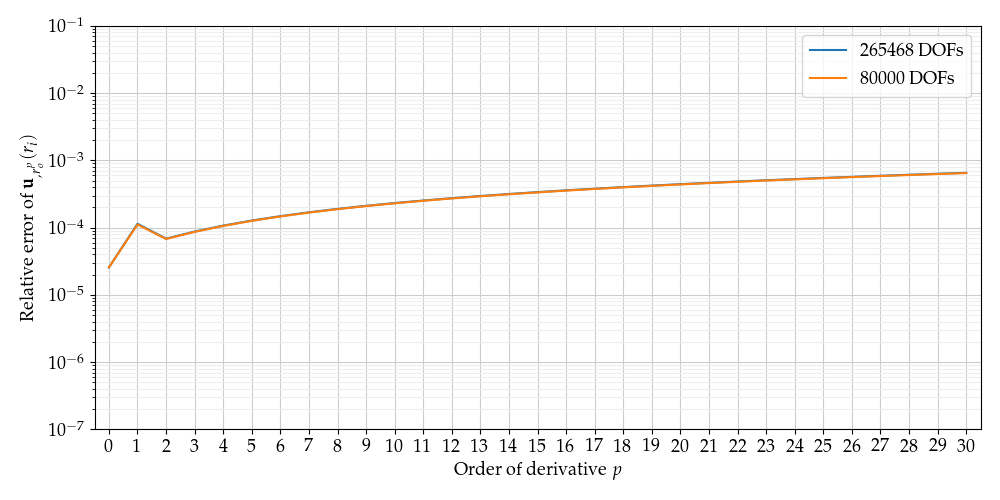

In [132]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':13})
plt.figure(figsize=(10,5))
new_order = 30
xvals  = range(new_order+1)#order+1)



yvals = errors_h003[:new_order+1]
plt.semilogy(xvals,yvals, label='{0} DOFs'.format(132734*2))

yvals = errors[:new_order+1]
plt.semilogy(xvals,yvals, label='{0} DOFs'.format(40000*2))


ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set_axisbelow(True)
# plt.rc('xtick',fontsize=14)
plt.grid(which='major',color='#CCCCCC')
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.axis([-0.5,len(xvals)-1+0.5,1e-7, 1e-1])
plt.ylabel("Relative error of $\mathbf{u}_{, r_{o}^{p}}(r_{i})$")
plt.xlabel("Order of derivative $p$")
plt.legend()
plt.tight_layout()

plt.savefig("imgs/error_dudro_n"+str(new_order)+".pdf",dpi=150)
plt.show()

In [ ]:
-1.1524403107115262e+29

In [50]:
dudE_ra[5,0]

0.00038619428571428564

In [34]:
# eps = 1e-120
# u_rerr   =(u.real-(u_a.real+eps))#/(u_a.real+eps)
dudE_rerr=np.abs(dudE_r - dudE_ra)/np.abs(dudE_ra)

In [35]:
np.max(np.abs(dudE_rerr[1:,:]))

2.0458541188075893e-05

<IPython.core.display.Javascript object>


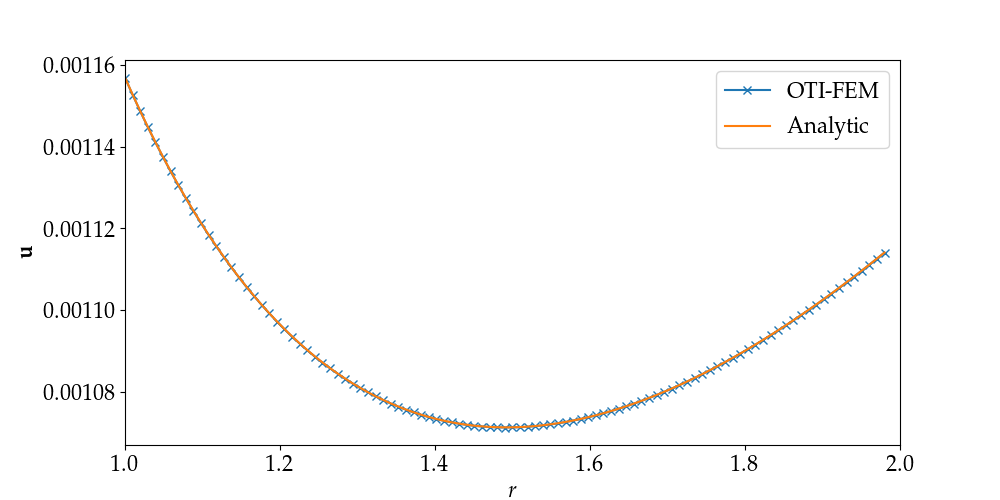

In [43]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})

plt.figure(figsize=(10,5))

grid = Th.to_pv(pd = [u_r],pd_names=['u'])
eps = 1e-2

a = [(ri.real+eps)*np.cos(np.pi/6),(ri.real+eps)*np.sin(np.pi/6),0]
b = [(ro.real-eps)*np.cos(np.pi/6),(ro.real-eps)*np.sin(np.pi/6),0]

grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

ax = plt.gca()

lines = ax.get_lines()
line = lines[0]
line.set_label("OTI-FEM")
line.set_marker("x")

x = line.get_xdata()
line.set_xdata(x+ri.real)












grid = Th.to_pv(pd = [u_ra],pd_names=['ua'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Analytic")

x = line.get_xdata()
line.set_xdata(x+ri.real)

plt.xlabel("$r$")
plt.ylabel("$\\mathbf{u}$")
# plt.title("OTI solution vs Analytic solution")
plt.title("")
plt.legend()#loc='lower right')
plt.axis([ri.real,ro.real,None,None])
plt.savefig("imgs/solution_u.pdf",dpi=150)
#plt.legend()
plt.show()

In [26]:
def analytic_solution_xy(x,y,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)
    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
    ux = ur*x/r
    uy = ur*y/r
    
    return ux, uy

In [85]:
x = Th.x[i,0]

In [90]:
x30 = x**30
x30.truncate([[1,30]])

0.0458 + 0.6863 * e([1]) + 4.9754 * e([[1,2]]) + 23.2180 * e([[1,3]]) + 78.3582 * e([[1,4]]) + 203.7250 * e([[1,5]]) + 424.4138 * e([[1,6]]) + 727.5436 * e([[1,7]]) + 1045.8110 * e([[1,8]]) + 1278.1732 * e([[1,9]]) + 1342.0396 * e([[1,10]]) + 1219.9976 * e([[1,11]]) + 965.8011 * e([[1,12]]) + 668.6105 * e([[1,13]]) + 405.9293 * e([[1,14]]) + 216.4888 * e([[1,15]]) + 101.4759 * e([[1,16]]) + 41.7829 * e([[1,17]]) + 15.0878 * e([[1,18]]) + 4.7644 * e([[1,19]]) + 1.3102 * e([[1,20]]) + 0.3119 * e([[1,21]]) + 0.0638 * e([[1,22]]) + 0.0111 * e([[1,23]]) + 0.0016 * e([[1,24]]) + 0.0002 * e([[1,25]]) + 0.0000 * e([[1,26]]) + 0.0000 * e([[1,27]]) + 0.0000 * e([[1,28]]) + 0.0000 * e([[1,29]])

In [91]:
t = np.linspace(0.00,1.0,50)
orders_ti = np.array([30,20,15,10,8,6,4,3,2,1],dtype=np.uint8)
error_ti = np.zeros((orders_ti.size,t.size))

kk=0



for ordi in orders_ti:
    u_for_ti = u.truncate([[1,ordi+1]])
    k=0
    for delta in t:
        u_r_ti = np.linalg.norm(u_for_ti.taylor_integrate([1],[delta]).real,axis=1).reshape((u.shape[0],-1))
        ux_a_ti, uy_a_ti = analytic_solution_xy(Th.x.taylor_integrate([1],[delta]).real,
                                            Th.y.taylor_integrate([1],[delta]).real,
                                            E.real,nu.real,ri.real,Pi.real,
                                            ro.taylor_integrate([1],[delta]).real,Po.real)
        u_a_ti = np.zeros(u.shape)
        u_a_ti[:,0:1]=ux_a_ti
        u_a_ti[:,1:2]=uy_a_ti
        u_ra_ti = np.linalg.norm(u_a_ti.real,axis=1).reshape((u_a.shape[0],-1))

        error_ti[kk,k]=abs( (u_r_ti[i,0]-u_ra_ti[i,0])/(u_ra_ti[i,0]) )

        k+=1

    #
    kk+=1
error_ti

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


array([[2.56299607e-05, 2.52994409e-05, 2.49797594e-05, 2.46702623e-05,
        2.43703506e-05, 2.40794754e-05, 2.37971321e-05, 2.35228564e-05,
        2.32562206e-05, 2.29968294e-05, 2.27443176e-05, 2.24983469e-05,
        2.22586033e-05, 2.20247954e-05, 2.17966520e-05, 2.15739204e-05,
        2.13563649e-05, 2.11437654e-05, 2.09359160e-05, 2.07326236e-05,
        2.05337073e-05, 2.03389966e-05, 2.01483298e-05, 1.99615494e-05,
        1.97784886e-05, 1.95989320e-05, 1.94224978e-05, 1.92483044e-05,
        1.90740583e-05, 1.88936496e-05, 1.86910377e-05, 1.84252003e-05,
        1.79942109e-05, 1.71519318e-05, 1.53199612e-05, 1.11737558e-05,
        1.75320568e-06, 1.94062723e-05, 6.61183475e-05, 1.67297638e-04,
        3.82295649e-04, 8.30699147e-04, 1.74924782e-03, 3.59879895e-03,
        7.26225747e-03, 1.44054684e-02, 2.81260496e-02, 5.41043276e-02,
        1.02618873e-01, 1.92033006e-01],
       [2.56299607e-05, 2.52994409e-05, 2.49797594e-05, 2.46702623e-05,
        2.43703506e-05,

<IPython.core.display.Javascript object>


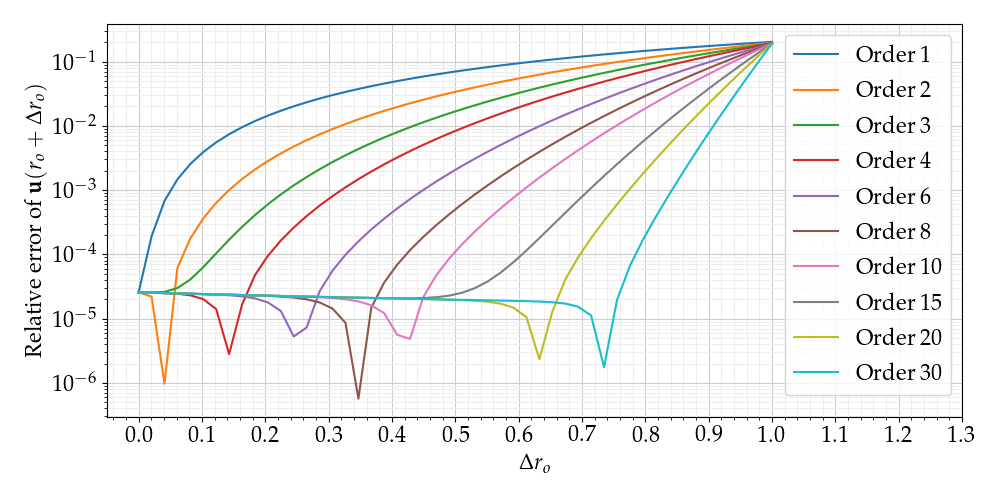

In [96]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})

plt.figure(figsize=(10,5))
norders = len(orders_ti)
for kk in range(norders):
    plt.semilogy(t,error_ti[-1-kk,:],label="Order "+str(orders_ti[-1-kk]))

plt.ylabel("Relative error of $\mathbf{u}(r_o+\Delta r_o)$")
plt.xlabel("$\Delta r_o$")
plt.legend()

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(0.1))

ax.set_axisbelow(True)
# plt.rc('xtick',fontsize=14)
plt.grid(which='major',color='#CCCCCC')
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')

ax.xaxis.set_minor_locator(MultipleLocator(0.02))
# plt.axis([-0.5,len(xvals)-1+0.5,1e-7, 1e-1])
# plt.ylabel("Relative error of $\mathbf{u}_{, r_{o}^{p}}(r_{i})$")
# plt.xlabel("Order of derivative $p$")
plt.axis([None,1.3,None,None])
plt.tight_layout()
plt.savefig("imgs/error_ti.pdf",dpi=150)
plt.show()

<IPython.core.display.Javascript object>


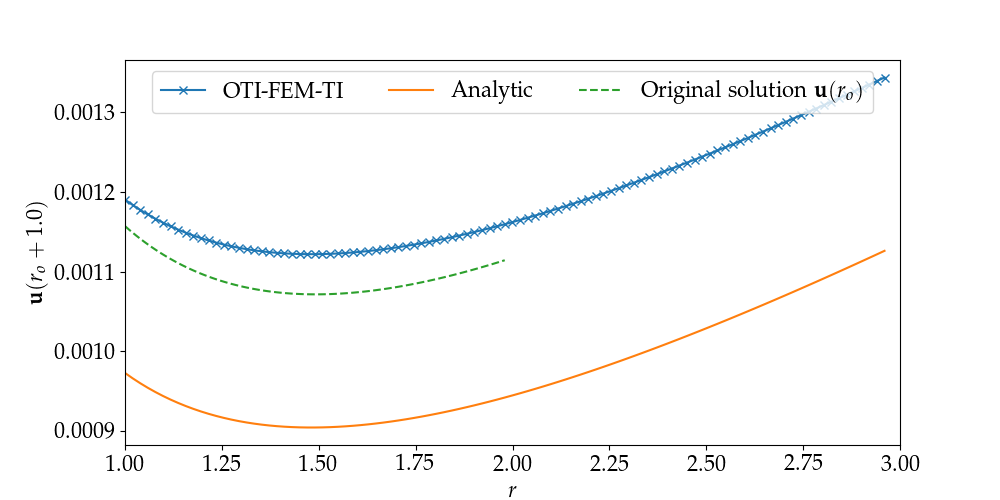

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [127]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})

plt.figure(figsize=(10,5))






delta = 1.0







u_r_ti = np.linalg.norm(u.taylor_integrate([1],[delta]).real,axis=1).reshape((u.shape[0],-1))


grid = Th.to_pv(pd = [u_r_ti],pd_names=['u'])
eps = 1e-2

a = [(ri.real+eps)*np.cos(np.pi/6),(ri.real+eps)*np.sin(np.pi/6),0]
b = [(ro.real-eps)*np.cos(np.pi/6),(ro.real-eps)*np.sin(np.pi/6),0]

grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

ax = plt.gca()

lines = ax.get_lines()
line = lines[0]
line.set_label("OTI-FEM-TI")
line.set_marker("x")

x = line.get_xdata()
line.set_xdata(x*(1+delta)+ri.real)










ux_a_ti, uy_a_ti = analytic_solution_xy(Th.x.taylor_integrate([1],[delta]).real,
                                        Th.y.taylor_integrate([1],[delta]).real,
                                        E.real,nu.real,ri.real,Pi.real,
                                        ro.taylor_integrate([1],[delta]).real,Po.real)
u_a_ti = np.zeros(u.shape)
u_a_ti[:,0:1]=ux_a_ti
u_a_ti[:,1:2]=uy_a_ti
u_ra_ti = np.linalg.norm(u_a_ti.real,axis=1).reshape((u_a.shape[0],-1))

















grid = Th.to_pv(pd = [u_ra_ti],pd_names=['ua'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Analytic")

x = line.get_xdata()
line.set_xdata(x*(1+delta)+ri.real)













grid = Th.to_pv(pd = [u_ra],pd_names=['ua'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Original solution $\mathbf{u}(r_o)$")

x = line.get_xdata()
line.set_xdata(x+ri.real)
line.set_linestyle('--')















plt.xlabel("$r$")
plt.ylabel("$\\mathbf{{u}}(r_o+{0})$".format(delta))
# plt.title("OTI solution vs Analytic solution")
plt.title("")
plt.legend(loc='upper center', ncol=3)
plt.axis([ri.real,ro.real+delta,None,None])
plt.savefig("imgs/solution_u_ti_delta_{0}.pdf".format(delta),dpi=150)
#plt.legend()
plt.show()

<IPython.core.display.Javascript object>


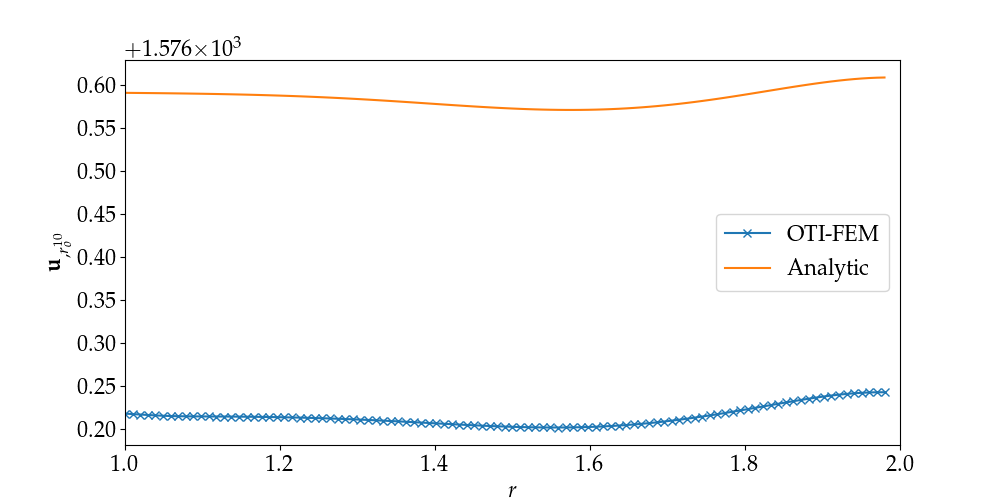

In [42]:
plt.figure(figsize=(10,5))


new_order = 10

dudE = u.get_deriv( [[1,new_order]] )
dudE[0,0:2] = np.nan
dudE_r = np.linalg.norm(dudE.real,axis=1).reshape((dudE.shape[0],-1))
dudE_r



dudE_a = u_a.get_deriv([[1,new_order]])
dudE_a[0,0:2] = np.nan
dudE_ra = np.linalg.norm(dudE_a.real,axis=1).reshape((dudE_a.shape[0],-1))






grid = Th.to_pv(pd = [dudE_r],pd_names=['oti'])

eps = 1e-2

a = [(ri.real+eps)*np.cos(np.pi/6),(ri.real+eps)*np.sin(np.pi/6),0]
b = [(ro.real-eps)*np.cos(np.pi/6),(ro.real-eps)*np.sin(np.pi/6),0]

grid.plot_over_line(a, b, resolution=100, figure=False, show=False )
ax = plt.gca()

lines = ax.get_lines()
line = lines[0]
line.set_label("OTI-FEM")
line.set_marker("x")


x = line.get_xdata()
line.set_xdata(x+ri.real)





grid = Th.to_pv(pd = [dudE_ra],pd_names=['analytic'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )
ax = plt.gca()
lines = ax.get_lines()
line = lines[-1]
line.set_label("Analytic")
x = line.get_xdata()
line.set_xdata(x+ri.real)


# Rescale x axis
# for line in lines:
    



plt.xlabel("$r$")
# plt.ylabel("30th order derivative of u w.r.t. E")
# plt.title("OTI solution vs Analytic solution")
plt.title("")
str_order = " "
if new_order != 1:
    str_order = str(new_order)
# end if 
plt.ylabel("$\\mathbf{u}_{,r_{o}^{"+str_order+"}}$")
plt.legend()#loc='upper right')
plt.axis([ri.real,ro.real,None,None])
plt.savefig('imgs/solution_dudro_n'+str(new_order)+'.pdf',dpi=150)
plt.show()

numpy.ndarray

In [123]:
import pyvista as pv
p = pv.BackgroundPlotter()
args_cbar = dict(height=0.75, vertical=True, position_x=0.05, 
                 position_y=0.05, interactive=False,
                 title_font_size=30, label_font_size=30)

In [124]:
p.set_background("white")

r = alg.sqrt(Th.x**2 + Th.y**2)

pert = r.get_deriv([1])

grid = Th.to_pv(pd = [pert],pd_names=['h'])

factor = 100
p.clear()

p.add_mesh(grid.warp_by_scalar(factor=1), show_edges=True, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args=args_cbar)
# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,color='grey', scalar_bar_args=args_cbar)
# p.add_mesh(arrows, lighting=False, stitle="u", scalar_bar_args=args_cbar)
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()


In [125]:
grid.save("cylinder_pert.vtk")

1

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
# pv.set_plot_theme('default')
p.set_background("white")
grid = Th.to_pv(pd = [u_a.real],pd_names=['u'])
factor = 100
p.clear()

# arrows = grid.glyph(scale="u", orient="u", factor = 100,tolerance=0.001)

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args=args_cbar)
# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,color='grey', scalar_bar_args=args_cbar)
# p.add_mesh(arrows, lighting=False, stitle="u", scalar_bar_args=args_cbar)
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()


In [ ]:
arrows

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
# pv.set_plot_theme('default')
p.set_background("white")
grid = Th.to_pv(pd = [u.real],pd_names=['u'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args=args_cbar)
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u_a.real],pd_names=['u_analytic'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [np.abs((u_r-u_ra)/u_ra)],pd_names=['relative error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u.real-u_a.real],pd_names=['absolute error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u.real-u_a.real],pd_names=['absolute error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [u_rerr],pd_names=['relative error'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet')#, scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [dudEc],pd_names=['dudE_oti'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
# import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [dudE_analytic],pd_names=['dudE_analytic'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
import pyvista as pv
p = pv.BackgroundPlotter()
pv.set_plot_theme('document')
grid = Th.to_pv(pd = [dudE-dudE_analytic],pd_names=['10th deriv  abs. error.'])
factor = 100
p.clear()

# p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=16,cmap='jet')
# p.add_mesh(grid, show_edges=True, line_width=2,grid = True,categories=256,cmap='jet')
p.add_mesh(grid, show_edges=False, line_width=2,grid = True,categories=256,cmap='jet', scalar_bar_args={'interactive':True})
# p.update_coordinates(grid.points + u*factor)

p.show_bounds()
p.show_grid()

In [ ]:
x = Th.x.real
y = Th.y.real

In [17]:
# Analytic solution
def analytic_solution_s(x,y,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)

    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
#     ux = ur*x/r
#     uy = ur*y/r
    
    return ur

In [18]:

import sympy as sym
Es, nus, ris, Pis, ros, Pos, xs, ys = sym.symbols("E nu r_i P_i r_o P_o x y")

In [19]:
urs = analytic_solution_s(xs,ys,Es,nus,ris,Pis,ros,Pos)
d30udro = urs.diff(ros,30)

In [20]:
d30udro

-265252859812191058636308480000000*(nu + 1)*(x**2 + y**2)**0.5*(1073741824*P_o*r_o**30*(2*nu - 1)/(r_i**2 - r_o**2)**15 + 7784628224*P_o*r_o**28*(2*nu - 1)/(r_i**2 - r_o**2)**14 + 25367150592*P_o*r_o**26*(2*nu - 1)/(r_i**2 - r_o**2)**13 + 49073356800*P_o*r_o**24*(2*nu - 1)/(r_i**2 - r_o**2)**12 + 62704844800*P_o*r_o**22*(2*nu - 1)/(r_i**2 - r_o**2)**11 + 55710842880*P_o*r_o**20*(2*nu - 1)/(r_i**2 - r_o**2)**10 + 35283533824*P_o*r_o**18*(2*nu - 1)/(r_i**2 - r_o**2)**9 + 16066609152*P_o*r_o**16*(2*nu - 1)/(r_i**2 - r_o**2)**8 + 5239111680*P_o*r_o**14*(2*nu - 1)/(r_i**2 - r_o**2)**7 + 1203937280*P_o*r_o**12*(2*nu - 1)/(r_i**2 - r_o**2)**6 + 189190144*P_o*r_o**10*(2*nu - 1)/(r_i**2 - r_o**2)**5 + 19348992*P_o*r_o**8*(2*nu - 1)/(r_i**2 - r_o**2)**4 + 1188096*P_o*r_o**6*(2*nu - 1)/(r_i**2 - r_o**2)**3 + 38080*P_o*r_o**4*(2*nu - 1)/(r_i**2 - r_o**2)**2 + 480*P_o*r_o**2*(2*nu - 1)/(r_i**2 - r_o**2) + P_o*(2*nu - 1) + 1073741824*r_i**2*r_o**32*(P_i - P_o)*(x**2 + y**2)**(-1.0)/(r_i**2 - r_o**2)

In [48]:
factor = 1
for i in range(1,31):
    factor *= i
factor

265252859812191058636308480000000

In [ ]:
ux_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uxs)
duxdE_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uxs.diff(Es,1))

uy_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uys)
duydE_eval = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos],uys.diff(Es,1))

In [ ]:
ux_eval(1,0,E.real,nu.real,ri.real, Pi.real, ro.real, Po.real)

In [ ]:
duxdE_eval(1,0,E.real,nu.real,ri.real, Pi.real, ro.real, Po.real)

In [21]:
a_sol = sym.lambdify([ xs, ys, Es, nus, ris, Pis, ros, Pos], d30udro)

In [22]:
a_sol(0,ri.real,E.real,nu.real,ri.real,Pi.real,ro.real,Po.real)

-1.1524403107115262e+29